Downladed data from : https://www.kaggle.com/adhok93/presidentialaddress

Goal: Analyze the textual content of first term inaugral speeches of US presidents, and answer few questions.

### Data Preprocessing 

In [1]:
# Setting working directory, importing libraries and reading data from csv file.
import os
os.getcwd()
os.chdir('/Users/netisheth/Documents/TextAnalytics')
import pandas as pd 
import numpy as np
import string
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
stop_words = nltk.corpus.stopwords.words('english')
%matplotlib inline


data = pd.read_csv('inaug_speeches.csv')
data = data.drop(columns = ['Unnamed: 0'])
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data = data.drop(columns = ['Date'])
data['PresYear'] = data.Year.map(str) + ' ' + data.Name.map(str)

# Unique presidents in the data set.
len(data.Name.unique())

39

In [2]:
# Remove capitalization and punctuation from our corpus to easily identify and count unique words.
def clean_text(text):
    clean1 = re.sub(r'['+ string.punctuation + '’—”'+']', "", text.lower())
    return re.sub(r'\W+', ' ', clean1)
data['tokenized'] = data['text'].map(lambda x: clean_text(x))

# No of words in each speech
data['num_wds'] = data['tokenized'].apply(lambda x: len(x.split()))

# Unique words in each speech
data['uniq_wds'] = data['tokenized'].str.split().apply(lambda x: len(set(x)))

#words15 = [w for w in words15 if w not in stop_words]
data['tokenized'] = data['text'].map(lambda x: clean_text(x))
data.head(3)

,Name,Inaugural Address,Party,text,Year,PresYear,tokenized,num_wds,uniq_wds
0,George Washington,First Inaugural Address,Other,Fellow-Citizens of the Senate and of the House...,1789,1789 George Washington,fellowcitizens of the senate and of the house ...,1427,594
1,George Washington,Second Inaugural Address,Other,Fellow Citizens: I AM again cal...,1793,1793 George Washington,fellow citizens i am again called upon by the...,135,90
2,John Adams,Inaugural Address,Other,"WHEN it was first perceived, in early times, t...",1797,1797 John Adams,when it was first perceived in early times tha...,2317,794


### 1. Which president has the most vocabulary as evident from their inaugural speeches, and which presidents has the least vocabulary? On average, do Democratic, Republican, or other presidents have higher vocabulary?

In [3]:
# President with most and least vocabulary
max_vocab = data[data['uniq_wds'] == data['uniq_wds'].max()].Name
min_vocab = data[data['uniq_wds'] == data['uniq_wds'].min()].Name
print("President with most vocabulary: " + max_vocab.to_string(index=False))
print("President with least vocabulary: " + min_vocab.to_string(index=False))

President with most vocabulary:  William Henry Harrison
President with least vocabulary:  George Washington


In [4]:
# Mean vocabulary for different party presidents
party_gp = data.groupby('Party')
party_gp['uniq_wds'].agg(np.mean)

Party
Democratic    711.227273
Other         784.083333
Republican    811.541667
Name: uniq_wds, dtype: float64

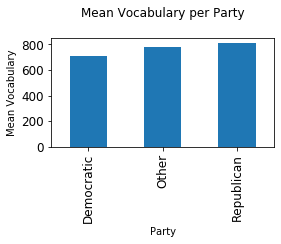

In [5]:
# Plotting mean vocabulary for different parties
ax=party_gp['uniq_wds'].aggregate(np.mean).plot(kind='bar', fontsize=12, figsize=(4,2))
ax.set_title('Mean Vocabulary per Party\n', fontsize=12)
ax.set_ylabel('Mean Vocabulary', fontsize=10)
ax.set_xlabel('Party', fontsize=10);

On average, Republican party presidents have higher vocabulary.

### 2. Create a barplot of presidential vocabulary from the earliest president (Washington) to the latest (Trump) in this sample of presidential speeches (excluding stop words). Either color code this barplot for Democratic (blue), Republican (red), and other (gray) presidents, or create three separate barplots for Democratic, Republican, and other presidents respectively.

In [6]:
# Removing stop words from speech
def removeStopWords(text) :
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return words

data['vocab_words'] = removeStopWords(data['tokenized'].str)
data['uniq_wds'] = data['vocab_words'].apply(lambda x: len(set(x)))

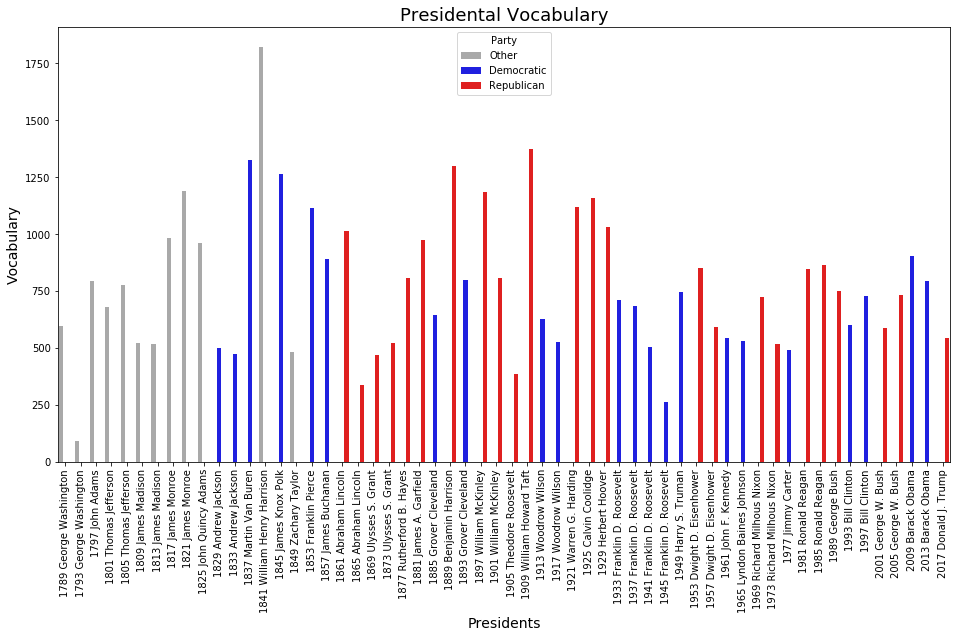

In [7]:
colors = ['#A9A9A9', '#0000FF', '#FF0000']
plt.figure(figsize=(16, 8))
plt.xticks(rotation='vertical')
ax = sns.barplot(x="PresYear", y="uniq_wds", hue="Party", data=data, palette=colors)
ax.set_title('Presidental Vocabulary', fontsize=18)
ax.set_ylabel('Vocabulary', fontsize=14)
ax.set_xlabel('Presidents', fontsize=14)
plt.show()

### 3. What are the five most frequently used words (exclusive of stop words) used by each president? Do Democratic presidents use a different set of words than Republican presidents? 

In [8]:
# 5 most frequently used words by each president
def get5CommonWords(text):
    words = nltk.tokenize.word_tokenize(speech)
    words = [w for w in words if w not in stop_words]
    words = [w for w in words if w.isalpha()]
    most_occur = Counter(words).most_common(5) 
    return ', '.join([word[0] for word in most_occur])

for i in data.index:
    speech = data.loc[i, 'tokenized']
    data.loc[i, 'Top 5 Freq Words'] = get5CommonWords(speech)

data[['Name', 'Year', 'Top 5 Freq Words']].style.hide_index()

Name,Year,Top 5 Freq Words
George Washington,1789,"every, government, public, may, present"
George Washington,1793,"shall, oath, fellow, citizens, called"
John Adams,1797,"people, government, may, nations, country"
Thomas Jefferson,1801,"government, us, may, let, fellowcitizens"
Thomas Jefferson,1805,"public, may, fellowcitizens, state, us"
James Madison,1809,"nations, public, country, well, peace"
James Madison,1813,"war, country, united, every, british"
James Monroe,1817,"great, government, states, people, us"
James Monroe,1821,"great, states, would, united, war"
John Quincy Adams,1825,"union, government, upon, rights, peace"


In [9]:
# Grouping president based on Party
party_gp = data.groupby('Party')
other = party_gp.get_group('Other')
demo = party_gp.get_group('Democratic')
repub = party_gp.get_group('Republican')

# Merging all the president speeches from the same party
demo_speech = pd.Series(demo.tokenized).str.cat(sep=' ')
repub_speech = pd.Series(repub.tokenized).str.cat(sep=' ')

# Get 5 most frequent words for democratic and republican party
print('5 most frequent words::')
print('Democratic party: ' + get5CommonWords(demo_speech))
print('Republican party: ' + get5CommonWords(repub_speech))

5 most frequent words::
Democratic party: america, american, people, country, one
Republican party: america, american, people, country, one


It is interesting to know that the 5 most frequent words for Democratic and Republican party presidents are the same.

### 4. Compute a sentiment (positive/negative) for each president, and draw three barplots of Democratic, Republican, and other presidents in chronological order. Which of these groups have higher mean sentiment score? Who are the top three presidents with the highest positive sentiment in each group?

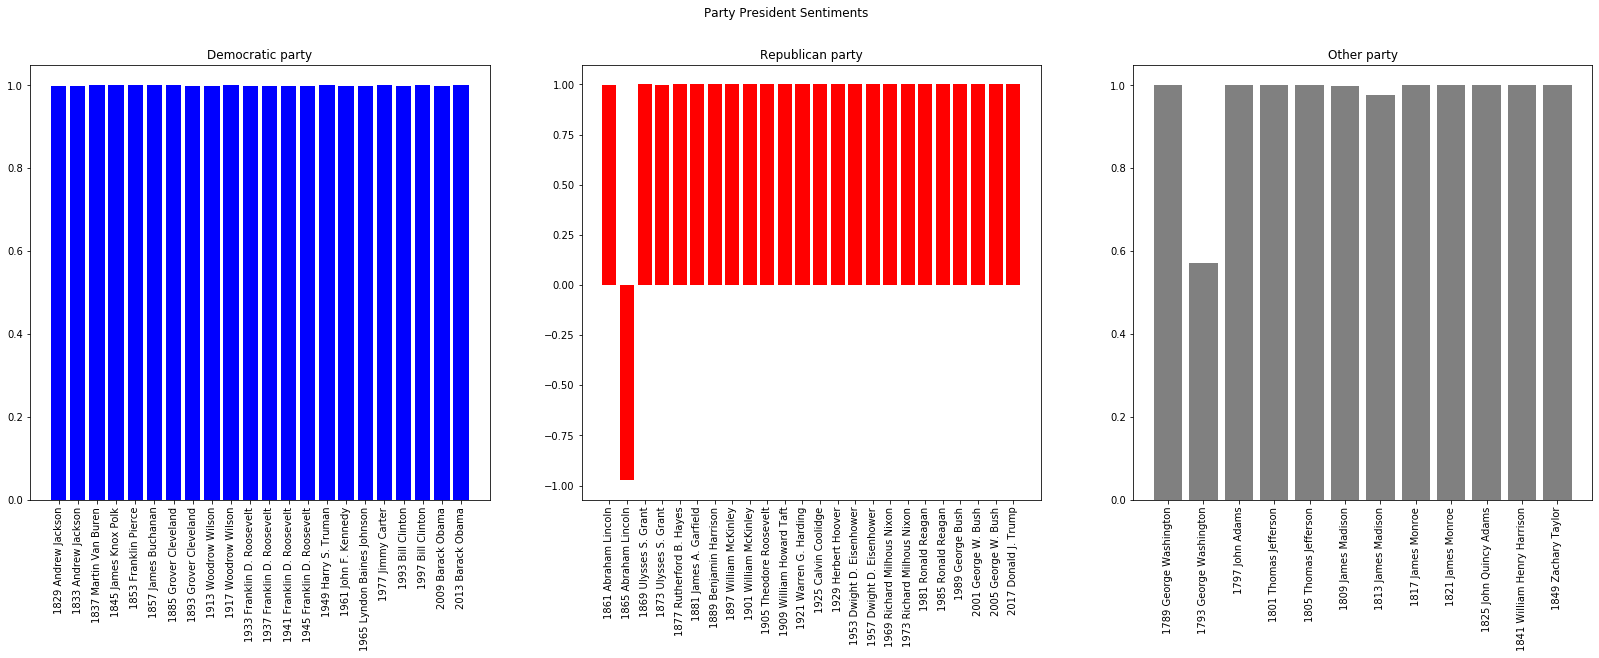

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Computing sentiment score for each president
for i in data.index:
    speech_text = data.loc[i, 'tokenized']
    sentiment = analyzer.polarity_scores(speech_text)
    polarity = sentiment['compound']
    data.loc[i, 'polarity'] = polarity

# Grouping president based on Party
party_gp = data.groupby('Party')
other = party_gp.get_group('Other')
demo = party_gp.get_group('Democratic')
repub = party_gp.get_group('Republican')

# Plot of president sentiments from different parties
plt.figure(figsize=(28, 8))

plt.subplot(131)
plt.bar(demo.PresYear, demo.polarity, color = 'blue')
plt.xticks(rotation='vertical')
plt.title('Democratic party')

plt.subplot(132)
plt.bar(repub.PresYear, repub.polarity, color = 'red')
plt.xticks(rotation='vertical')
plt.title('Republican party')

plt.subplot(133)
plt.bar(other.PresYear, other.polarity, color = 'grey')
plt.xticks(rotation='vertical')
plt.title('Other party')

plt.suptitle('Party President Sentiments')
plt.show()

In [11]:
# Mean sentiment score of every party
party_gp['polarity'].agg(np.mean)

Party
Democratic    0.999591
Other         0.962150
Republican    0.917725
Name: polarity, dtype: float64

Democratic party has the highest mean sentiment score - 0.999591.

In [12]:
# Dropping duplicate rows with same president name, parties and sentiment polarity.
data = data.drop_duplicates(['Name', 'Party', 'polarity'])

# Top three presidents with the highest positive sentiment in each group
sorted_df = data.sort_values(by=['polarity', 'Party'],ascending=False).groupby('Party')['Name', 'Party', 'polarity'].head(3)
print('Top 3 presidents with the highest positive sentiment in each group are: ')
sorted_df.style.hide_index()

Top 3 presidents with the highest positive sentiment in each group are: 


Name,Party,polarity
Rutherford B. Hayes,Republican,1
Benjamin Harrison,Republican,1
William McKinley,Republican,1
John Adams,Other,1
James Monroe,Other,1
William Henry Harrison,Other,1
James Knox Polk,Democratic,1
Franklin Pierce,Democratic,1
Harry S. Truman,Democratic,1
